# Calibration of the deflection of a tube

## Create a calibration problem

In [1]:
import openturns as ot
ot.RandomGenerator.SetSeed(0)

We use the variable names `De` for the external diameter and `di` for the internal diameter because the symbolic function engine is not case sensitive, hence the variable names `D` and `d` would not be distiguished.

In [2]:
inputsvars=["F","L","a","De","di","E"]
formula = "var I:=pi_*(De^4-di^4)/32; var b:=L-a; g1:=-F*a^2*(L-a)^2/(3*E*L*I); g2:=-F*b*(L^2-b^2)/(6*E*L*I)*1.e6; g3:=F*a*(L^2-a^2)/(6*E*L*I)*1.e6"
g = ot.SymbolicFunction(inputsvars,["g1","g2","g3"],formula)
g.setOutputDescription(["Deflection","Left angle","Right angle"])

In [3]:
XF=ot.Normal(1,0.1)
XE=ot.Normal(2e5,2e3)
XF.setDescription(["Force"])
XE.setDescription(["Young Modulus"])

In [4]:
XL = ot.Dirac(1.5)
Xa = ot.Dirac(1.0)
XD = ot.Dirac(0.8)
Xd = ot.Dirac(0.1)
XL.setDescription(["Longueur"])
Xa.setDescription(["Location"])
XD.setDescription(["External diameter"])
Xd.setDescription(["Internal diameter"])

In [5]:
inputDistribution = ot.ComposedDistribution([XF,XL,Xa,XD,Xd,XE])

In [6]:
sampleSize = 10
inputSample = inputDistribution.getSample(sampleSize)
inputSample[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=6 description=[Force,Longueur,Location,External diameter,Internal diameter,Young Modulus] data=[[1.06082,1.5,1,0.8,0.1,199059],[0.873383,1.5,1,0.8,0.1,200522],[0.956173,1.5,1,0.8,0.1,195420],[1.12055,1.5,1,0.8,0.1,197434],[0.781861,1.5,1,0.8,0.1,197376]]

In [7]:
outputDeflection = g(inputSample)
outputDeflection[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=3 description=[Deflection,Left angle,Right angle] data=[[-7.36434e-06,-14.7287,18.4108],[-6.01889e-06,-12.0378,15.0472],[-6.76148e-06,-13.523,16.9037],[-7.84299e-06,-15.686,19.6075],[-5.47404e-06,-10.9481,13.6851]]

In [8]:
observationNoiseSigma = [0.1e-6,1.5,1.5]
observationNoiseCovariance = ot.CovarianceMatrix(3)
for i in range(3):
    observationNoiseCovariance[i,i] = observationNoiseSigma[i]**2

In [9]:
noiseSigma = ot.Normal([0.,0.,0.],observationNoiseCovariance)
sampleObservationNoise = noiseSigma.getSample(sampleSize)
observedOutput = outputDeflection + sampleObservationNoise
observedOutput[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=3 description=[Deflection,Left angle,Right angle] data=[[-7.33205e-06,-14.06,16.8537],[-6.10456e-06,-11.3273,14.859],[-6.72634e-06,-10.8494,17.009],[-7.92113e-06,-16.7683,19.2456],[-5.65284e-06,-10.346,15.7368]]

In [10]:
observedInput = ot.Sample(sampleSize,2)
observedInput[:,0] = inputSample[:,0] # F
observedInput[:,1] = inputSample[:,5] # E
observedInput.setDescription(["Force","Young Modulus"])
observedInput[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=2 description=[Force,Young Modulus] data=[[1.06082,199059],[0.873383,200522],[0.956173,195420],[1.12055,197434],[0.781861,197376]]

In [11]:
fullSample = ot.Sample(sampleSize,5)
fullSample[:,0:2] = observedInput
fullSample[:,2:5] = observedOutput
fullSample.setDescription(["Force","Young","Deflection","Left Angle","Right Angle"])
fullSample[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=5 description=[Force,Young,Deflection,Left Angle,Right Angle] data=[[1.06082,199059,-7.33205e-06,-14.06,16.8537],[0.873383,200522,-6.10456e-06,-11.3273,14.859],[0.956173,195420,-6.72634e-06,-10.8494,17.009],[1.12055,197434,-7.92113e-06,-16.7683,19.2456],[0.781861,197376,-5.65284e-06,-10.346,15.7368]]

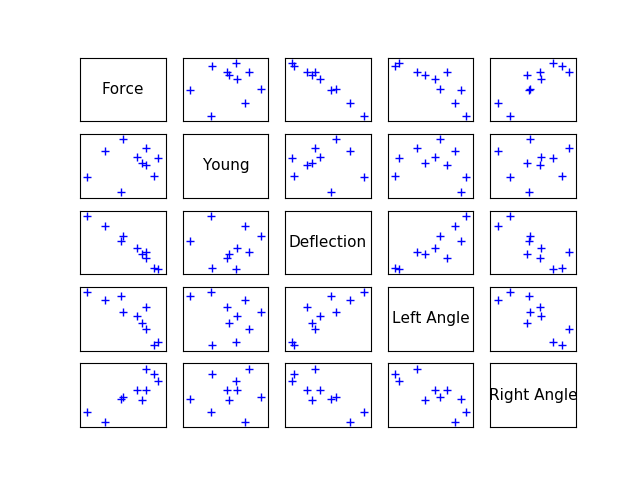

In [12]:
ot.Pairs(fullSample)

## Setting up the calibration

In [13]:
XL = 1.4 # Exact : 1.5
Xa = 1.2 # Exact : 1.0
XD = 0.7 # Exact : 0.8
Xd = 0.2 # Exact : 0.1
thetaPrior = ot.Point([XL,Xa,XD,Xd])

In [14]:
sigmaXL = 0.1 * XL
sigmaXa = 0.1 * Xa
sigmaXD = 0.1 * XD
sigmaXd = 0.1 * Xd
parameterCovariance = ot.CovarianceMatrix(4)
parameterCovariance[0,0] = sigmaXL**2
parameterCovariance[1,1] = sigmaXa**2
parameterCovariance[2,2] = sigmaXD**2
parameterCovariance[3,3] = sigmaXd**2
parameterCovariance

class=CovarianceMatrix dimension=4 implementation=class=MatrixImplementation name=Unnamed rows=4 columns=4 values=[0.0196,0,0,0,0,0.0144,0,0,0,0,0.0049,0,0,0,0,0.0004]

In [15]:
calibratedIndices = [1,2,3,4]
calibrationFunction = ot.ParametricFunction(g, calibratedIndices, thetaPrior)

In [16]:
sigmaObservation = [0.2e-6,1.3,1.3] # Exact : [0.1e-6,1.5,1.5]

In [17]:
errorCovariance = ot.CovarianceMatrix(3)
errorCovariance[0,0] = sigmaObservation[0]**2
errorCovariance[1,1] = sigmaObservation[1]**2
errorCovariance[2,2] = sigmaObservation[2]**2

In [18]:
calibrationFunction.setParameter(thetaPrior)
predictedOutput = calibrationFunction(observedInput)
predictedOutput[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=3 description=[Deflection,Left angle,Right angle] data=[[-3.12137e-06,-10.4046,16.9074],[-2.5511e-06,-8.50366,13.8185],[-2.86585e-06,-9.55282,15.5233],[-3.32424e-06,-11.0808,18.0063],[-2.32017e-06,-7.73389,12.5676]]

## Calibration with gaussian linear least squares

In [19]:
algo = ot.GaussianLinearCalibration(calibrationFunction, observedInput, observedOutput, thetaPrior, parameterCovariance, errorCovariance)

In [20]:
algo.run()

In [21]:
calibrationResult = algo.getResult()

## Analysis of the results

In [22]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=4 values=[1.52085,1.04501,0.884491,0.199649]

Compute a 95% confidence interval for each marginal.

In [23]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.getCovariance()

class=CovarianceMatrix dimension=4 implementation=class=MatrixImplementation name=Unnamed rows=4 columns=4 values=[0.00720375,0.00733857,0.000981353,-1.86847e-06,0.00733857,0.0075243,0.000947296,-1.80362e-06,0.000981353,0.000947296,0.000197625,8.95317e-06,-1.86847e-06,-1.80362e-06,8.95317e-06,0.000399983]